# Can the KNeighborsRegressor be used for time series forecasting?

In this notebook, we will learn how to make time-series predictions with the *KNeighborsRegressor* model, the regression variant of the *k*-NN algorithm.

We will work with the Airline Passengers dataset, which provides the monthly number of airline passengers from 1949-1960 for an airline company. This dataset is available on Kaggle and can be downloaded [here](https://www.kaggle.com/abhishekmamidi/air-passengers#AirPassengers.csv). 

## Load the data

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data and create a datetime index
data = pd.read_csv("c4_AirPassengers.csv", index_col="Month", parse_dates=True)

# Rename columns for convenience
data.columns = ["Passengers"]
data.index.names = ["Date"]

# Print the shape of the dataframe
print("Data shape: {}".format(data.shape))

# Print a few samples
data.head()

Data shape: (144, 1)


,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Exploratory data analysis

Let's have a first look at the data.

In [3]:
# Register the converters

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

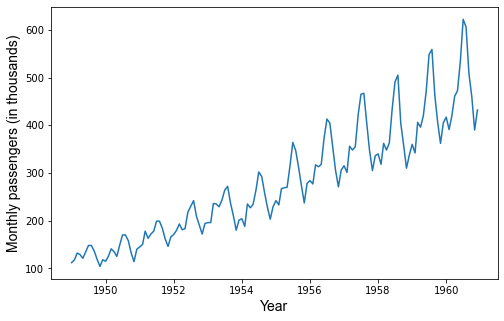

In [4]:
# Plot the number of passengers
plt.figure(figsize=(8, 5))

font_dict = {"fontname": "Arial", "size": "14"}

plt.plot(data["Passengers"])
plt.xlabel("Year", fontdict=font_dict)
plt.ylabel("Monthly passengers (in thousands)", fontdict=font_dict)

plt.show()

In [5]:
# Create a new colum: year
data["year"] = data.index.year

# Group by the 'year' and generate descriptive statistics
data.groupby("year").describe().T

year                    1949        1950        1951        1952        1953  \
Passengers count   12.000000   12.000000   12.000000   12.000000   12.000000   
           mean   126.666667  139.666667  170.166667  197.000000  225.000000   
           std     13.720147   19.070841   18.438267   22.966379   28.466887   
           min    104.000000  114.000000  145.000000  171.000000  180.000000   
           25%    118.000000  125.750000  159.000000  180.750000  199.750000   
           50%    125.000000  137.500000  169.000000  192.000000  232.000000   
           75%    135.250000  151.250000  179.500000  211.250000  238.500000   
           max    148.000000  170.000000  199.000000  242.000000  272.000000   

year                    1954        1955       1956        1957        1958  \
Passengers count   12.000000   12.000000   12.00000   12.000000   12.000000   
           mean   238.916667  284.000000  328.25000  368.416667  381.000000   
           std     34.924486   42.140458   47.86178   57.890898   64.530472   
           min    188.000000  233.000000  271.00000  301.000000  310.000000   
           25%    221.250000  260.750000  300.50000  330.750000  339.250000   
           50%    231.500000  272.000000  315.00000  351.500000  360.500000   
           75%    260.250000  312.750000  359.75000  408.500000  411.750000   
           max    302.000000  364.000000  413.00000  467.000000  505.000000   

year                    1959        1960  
Passengers count   12.000000   12.000000  
           mean   428.333333  476.166667  
           std     69.830097   77.737125  
           min    342.000000  390.000000  
           25%    387.500000  418.500000  
           50%    406.500000  461.000000  
           75%    465.250000  514.750000  
           max    559.000000  622.000000

Looking at the plot of the time-series and the table from above, we observe:  
* an increasing *trend*, as the *mean* number of passengers increases with time. For example, the mean number of passengers in 1949 is approximately 127. Six years later, in 1955, the average number of passengers has doubled (284) and, in 1960, is has almost quadrupled (476).
* a *seasonal pattern*, as summer months are more popular than winter months,
* that the annual variation in the data increases with time. In 1949, the number of passengers ranges from 104 to 148 (i.e., a total variation of 44 passengers), while in 1960, the total variation is 232 passengers!

We need to build forecasting models that take into account the trend, the seasonal pattern, and the increasing variation in the data.

In [6]:
# Remove column: 'year'
data.drop("year", axis=1, inplace=True)

### Data transformation

The variation in the magnitude of the time-series with time is referred to as *non-stationarity in the variance*. Non-constant variance is common in time-series data, and we need to account for it before building our models, as this will help to improve predictions. 

One way of stabilizing the variance is by applying a logarithm transformation to the target. Log-transforming the number of passengers will help to "stabilize" the annual variation in the data to form a time-series that has a variance approximately constant over time.

However, there is no "one-size-fits-all" solution for all data; other types of transformations (inverse, square root, cubic root, etc.) may work better in other cases.

In [7]:
# Log-transform 'Passengers'
data["Passengers"] = np.log(data["Passengers"])

# Print the head of the DataFrame
data.head()

,Passengers
Date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


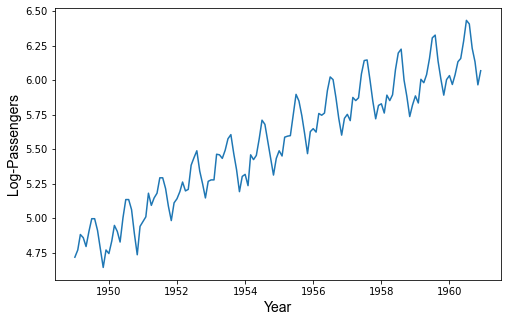

In [8]:
# Plot the log-transformed 'Passengers'

plt.figure(figsize=(8, 5))

plt.plot(data["Passengers"])
plt.xlabel("Year", fontdict=font_dict)
plt.ylabel("Log-Passengers", fontdict=font_dict)

plt.show()

We see that the log-transformation has helped to reduce the variation in size of the annual cycles in time.

## Fitting a first model

We will now to use *KNeighborsRegressor* to build a model that predicts the number of passengers in the next month. Before fitting our first model, let's have a look at the data once more.

In [9]:
data.head()

,Passengers
Date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


### Feature engineering: the *Time* feature

At the moment, *Date* is expressed in a "year-month-day" format, which is not very convenient as it cannot be "processed" by the model. 

Let's create a new feature *Time* that is equal to the number of months since the first timestamp in the data (January 1, 1949).

In [10]:
# New feature: 'Time'

data["Time"] = np.arange(0, data.shape[0])

# Print the head of the DataFrame
data[["Time", "Passengers"]].head()

,Time,Passengers
Date,,
1949-01-01,0,4.718499
1949-02-01,1,4.770685
1949-03-01,2,4.882802
1949-04-01,3,4.859812
1949-05-01,4,4.795791


### Training/test splitting for time-series data

We will now split into train, and test sets. We need to make sure that the test set covers a later period in time from the training set, to prevent any information about the future from "leaking" into the model during training. In this example, we will use the samples from 1949 to 1959 as our training set, and the last year in the data as our test set (1960).

Below, we define a function to split the data into training and test sets.

In [11]:
# Define a function to split the data into training and test sets


def train_test_split(df, start_dt):

    """
    This function performs train/test splitting for time-series data.

    Arguments
    ---------
    - df        : the data (features & target)
    - start_df  : the starting date for the test set

    Outputs
    -------
    - X_tr,y_tr : X/y arrays for train set
    - X_te,y_te : X/y arrays for test data
    """

    # Train set
    X_tr = df[df.index < test_start_dt].drop("Passengers", axis=1).values
    y_tr = df[df.index < test_start_dt]["Passengers"]

    # Test set
    X_te = df[df.index >= test_start_dt].drop("Passengers", axis=1).values
    y_te = df[df.index >= test_start_dt]["Passengers"]

    print("Train set")
    print("---------")
    print("Features: {} Target: {}\n".format(X_tr.shape, y_tr.shape))

    print("Test set")
    print("--------")
    print("Features: {} Target: {}".format(X_te.shape, y_te.shape))

    return (X_tr, X_te, y_tr, y_te)

In [12]:
# Split into train/test sets and create X/y arrays

# Set the starting date of the test set: Jan 1st, 1960
test_start_dt = "1960-01-01"

X_train, X_test, y_train, y_test = train_test_split(data, test_start_dt)

Train set
---------
Features: (132, 1) Target: (132,)

Test set
--------
Features: (12, 1) Target: (12,)


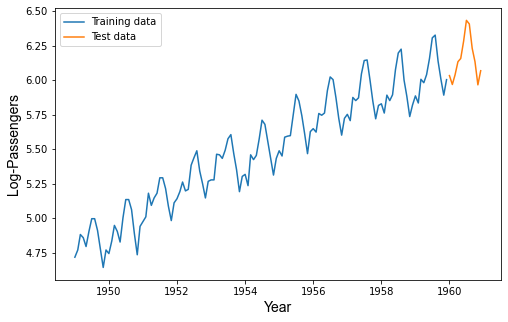

In [13]:
# Plot the train/test sets

plt.figure(figsize=(8, 5))

plt.plot(y_train, label="Training data")
plt.plot(y_test, label="Test data")

plt.xlabel("Year", fontdict=font_dict)
plt.ylabel("Log-Passengers", fontdict=font_dict)
plt.legend()
plt.show()

We will now fit *KNeighborsRegressor* and evaluate its performance using the Mean Absolute Error (MAE). The target *Passengers* is log-transformed. This means that we need to invert the log-transformed *Passengers* back to their original scale before computing the error of the model. We can invert log-transformations using Numpy's exponential function (*numpy.exp*).

In [14]:
# Mean Absolute error (MAE)
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))


# Invert log-transformation and compute model error
def model_error(y, y_pred):
    score = MAE(np.exp(y), np.exp(y_pred))  # Invert log-transformation and compute MAE
    return score

In [15]:
from sklearn.neighbors import KNeighborsRegressor

# Create and fit a KNeighborsRegressor model
knn = KNeighborsRegressor(
    n_neighbors=3, p=1, weights="distance"
)  # Hyperparameters: tuned with GridSearchCV (not shown here)
knn.fit(X_train, y_train)

# Compute predictions on train/test sets
y_pred_tr = knn.predict(X_train)
y_pred_te = knn.predict(X_test)

# Model performance
print("Model 1")
print("-------")
print()
print(
    "Train set - MAE score: {:.0f} passengers".format(model_error(y_train, y_pred_tr))
)
print("Test set  - MAE score: {:.0f} passengers".format(model_error(y_test, y_pred_te)))

Model 1
-------

Train set - MAE score: 0 passengers
Test set  - MAE score: 85 passengers


In [16]:
# Define a function to plot predictions


def plot_predictions(df, y_tr, y_te, y_pred_tr, y_pred_te, score_te):

    """
    This function plots the training/test data along with the predictions

    Arguments
    ---------
    - y_tr, y_te           : target (train/test sets)
    - y_pred_tr, y_pred_te : predictions (train/test sets)
    - score_te             : model error (test set)

    """

    font = {"fontname": "Arial", "size": "14"}
    font_title = {"fontname": "Arial", "size": "16"}

    plt.figure(figsize=(9, 6))

    # True values
    plt.plot(df.index[0 : len(y_tr)], np.exp(y_tr), label="train set", color="black")
    plt.plot(
        df.index[len(y_tr) : len(y_tr) + len(y_te)],
        np.exp(y_te),
        label="test set",
        color="grey",
    )

    # Predictions
    plt.plot(
        df.index[0 : len(y_tr)],
        np.exp(y_pred_tr),
        label="predictions train",
        color="blue",
    )
    plt.plot(
        df.index[len(y_tr) : len(y_tr) + len(y_te)],
        np.exp(y_pred_te),
        "-",
        label="predictions test",
        color="red",
    )

    plt.xlabel("Year", **font)
    plt.ylabel("Monthly passengers (in thousands)", **font)
    plt.title(
        "MAE score: {:.0f} passengers (test set)".format(score_te),
        fontsize=14,
        **font_title
    )

    plt.legend()
    plt.show()

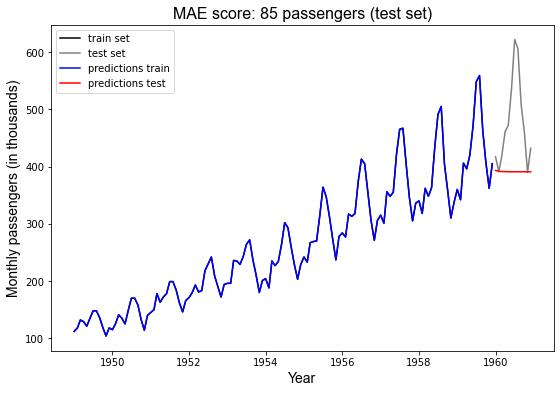

In [17]:
# Plot results

plot_predictions(
    data, y_train, y_test, y_pred_tr, y_pred_te, model_error(y_test, y_pred_te)
)

The predictions for the training set are good. However, for the test set, the model predicted a continuous line.

In the training data, the values of the *Time* feature range between 0 and 131, while in the test set they range between 132 and 143. The issue here is that *KNeighborsRegressor* cannot extrapolate to feature values outside the training set. As a result, for the test set, *KNeighborsRegressor* predicts the mean number of the passengers of the k-nearest neighbors from the training set, which are the last *3* timesteps in the training set.

## Fitting a second model

Let's see how we can improve our model. We will remove the *Time* feature, and we will add two new features: the *month* and the *year*. 

### Feature engineering: the *Year* and *Month* features

In [18]:
# Create new features: month and year
data["Year"] = data.index.year
data["Month"] = data.index.month

# Remove column 'Time'
data.drop("Time", axis=1, inplace=True)

data[["Month", "Year", "Passengers"]].head()

,Month,Year,Passengers
Date,,,
1949-01-01,1,1949,4.718499
1949-02-01,2,1949,4.770685
1949-03-01,3,1949,4.882802
1949-04-01,4,1949,4.859812
1949-05-01,5,1949,4.795791


In this second model, *Year* and *Month* are going to be the features and *Passengers* the target.

In [19]:
# Split into train/set sets and create X/y arrays

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data, test_start_dt)

Train set
---------
Features: (132, 2) Target: (132,)

Test set
--------
Features: (12, 2) Target: (12,)


In [20]:
# Show a few samples from the training data

X_train_2[0:3]

array([[1949,    1],
       [1949,    2],
       [1949,    3]], dtype=int64)

In [21]:
# Show a few samples from the test data

X_test_2[0:3]

array([[1960,    1],
       [1960,    2],
       [1960,    3]], dtype=int64)

Below we will fit a second *KNeighborsRegressor* model and evaluate its performance using the Mean Absolute Error (MAE).

In [22]:
# Fit a second KNeighborsRegressor model

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),  # Scaling improves performance
        ("knn", KNeighborsRegressor(n_neighbors=3, p=2, weights="distance")),
    ]
)  # Hyperparameters: tuned with GridSearchCV (not shown here)
pipe.fit(X_train_2, y_train_2)

# Compute predictions for train/test sets
y_pred_tr_2 = pipe.predict(X_train_2)
y_pred_te_2 = pipe.predict(X_test_2)

# Model performance
print("Model 2")
print("-------")
print()
print(
    "Train set - MAE score: {:.0f} passengers".format(
        model_error(y_train_2, y_pred_tr_2)
    )
)
print(
    "Test set  - MAE score: {:.0f} passengers".format(
        model_error(y_test_2, y_pred_te_2)
    )
)

Model 2
-------

Train set - MAE score: 0 passengers
Test set  - MAE score: 51 passengers


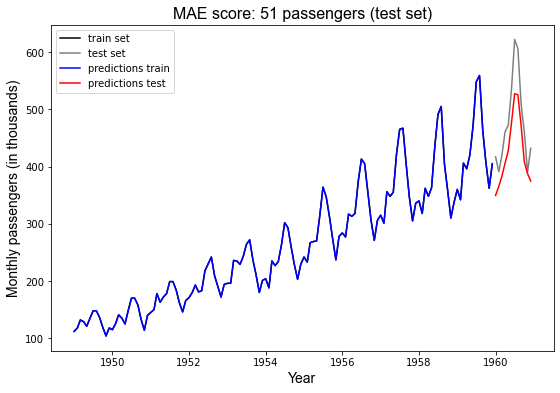

In [23]:
# Plot results

plot_predictions(
    data,
    y_train_2,
    y_test_2,
    y_pred_tr_2,
    y_pred_te_2,
    model_error(y_test_2, y_pred_te_2),
)

The predictions on the test set have improved, but we miss to capture the trend in the data. What this model is predicting at the moment is the mean number of passengers of the k-nearest neighbors in the training set. Unlike the first model, the k-nearest neighbors are now determined based on the month and year combination of the *k*-nearest neighbors in the training set, hence the improvement in the predictions.

## Fitting a third model  

Let's now see if we can further improve our model by eliminating the trend in the target. One way of removing the trend, i.e. the *non-stationarity in the mean*, is through *differencing*, which consists in computing the difference between consecutive observations. 

### Data preparation :: Differencing

Differencing can be achieved with the *pandas.DataFrame.diff* function. *Pandas.DataFrame.diff* first moves the time-series forward one position and then computes the difference with the original time-series (all in 1-step).

In [24]:
# Create a copy of the data
data1 = data.copy()

# Column "Passengers" : apply differencing
data1["Passengers"] = data1["Passengers"].diff()

# Show a few samples from the data
data1[["Month", "Year", "Passengers"]].head()

,Month,Year,Passengers
Date,,,
1949-01-01,1,1949,NaN
1949-02-01,2,1949,0.052186
1949-03-01,3,1949,0.112117
1949-04-01,4,1949,-0.022990
1949-05-01,5,1949,-0.064022


Computing the first difference of the time-series resulted in a missing value in the first entry of *Passengers*. We need to remove missing values from the data before fiting our third model.

In [25]:
# Remove rows with missing values
data1.dropna(inplace=True)

# Show a few samples from the data
data1[["Month", "Year", "Passengers"]].head()

,Month,Year,Passengers
Date,,,
1949-02-01,2,1949,0.052186
1949-03-01,3,1949,0.112117
1949-04-01,4,1949,-0.022990
1949-05-01,5,1949,-0.064022
1949-06-01,6,1949,0.109484


In [26]:
# Print the shape of the dataframe
print("Data shape: {}".format(data1.shape))

Data shape: (143, 3)


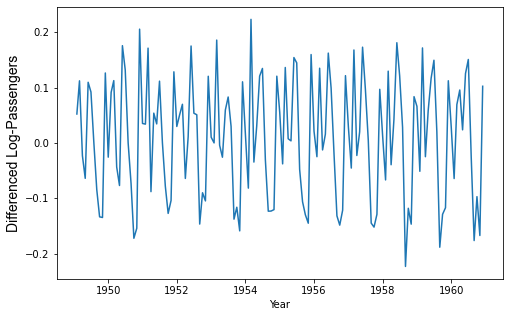

In [27]:
# Plot the new feature 'Passengers'

plt.figure(figsize=(8, 5))

plt.plot(data1["Passengers"])

plt.xlabel("Year")
plt.ylabel("Differenced Log-Passengers", fontdict=font_dict)

plt.show()

Taking the first difference of the *Passengers* returned a time-series of the month-to-month changes in the number of passengers, as shown above. We notice that differencing has helped to stabilize the mean value of the target *Passengers*.

We are now ready to fit our third model; *Year* and *Month* are going to be the features and *Passengers* (differenced and log-transformed) the target.

In [28]:
# Split into train/set sets and create X/y arrays

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(data1, test_start_dt)

Train set
---------
Features: (131, 2) Target: (131,)

Test set
--------
Features: (12, 2) Target: (12,)


In [29]:
# Create and fit KNeighborsRegressor

# Here: better results without scaling
knn3 = KNeighborsRegressor(
    n_neighbors=2, p=1, weights="distance"
)  # Hyperparameters: tuned with GridSearchCV
knn3.fit(X_train_3, y_train_3)

# Compute predictions on train/test sets
y_pred_tr_3 = knn3.predict(X_train_3)
y_pred_te_3 = knn3.predict(X_test_3)

### Invert differencing

Now, the target and the predictions are expressed as the month-to-month change in the number of passengers. We need to invert differencing to turn the target and the predictions back to their original scale before computing the error of the model.

Differencing can be inverted using Numpy's cumulative sum function ([numpy.cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html)). However, differencing threw away the first entry of the target *Passengers*. So, before calling the *cumsum* function, we need to put this value back together with the predictions on the train and test sets. 

In [30]:
# Define function to invert differencing


def invert_differencing(y_tr, y_te, y0, len_train):

    """
    This function inverts differencing of time-series data and
    re-splits the data into training/test sets.

    It takes the following arguments:
    - y_tr      : predictions on the train data (differenced)
    - y_te      : predictions on the test data (differenced)
    - y0        : the first entry of the target (before differencing)
    - len_train : number of samples in the training set (before differencing)

    Output:
    - y_train   : predictions of the train data (original scale)
    - y_test    : predictions of the test data (original scale)
    """

    y_tr_te_inv = np.r_[y0, y_tr, y_te].cumsum()  # Invert differencing
    y_train, y_test = (
        y_tr_te_inv[0:len_train],
        y_tr_te_inv[len_train:],
    )  # Train/test split

    return (y_train, y_test)

In [31]:
# Retrieve the first entry of the target which was thrown away after differencing
y0 = data["Passengers"][0]

# Define the number of samples in the train data (before differencing)
len_train = len(y_train)

# Target: Invert differencing
y_train_3, y_test_3 = invert_differencing(y_train_3, y_test_3, y0, len_train)

# Predictions: Invert differencing
y_pred_tr_3, y_pred_te_3 = invert_differencing(y_pred_tr_3, y_pred_te_3, y0, len_train)

In [32]:
# Model performance

print("Model 3")
print("-------")
print()
print(
    "Train set - MAE score: {:.0f} passengers".format(
        model_error(y_train_3, y_pred_tr_3)
    )
)
print(
    "Test set  - MAE score: {:.0f} passengers".format(
        model_error(y_test_3, y_pred_te_3)
    )
)

Model 3
-------

Train set - MAE score: 0 passengers
Test set  - MAE score: 13 passengers


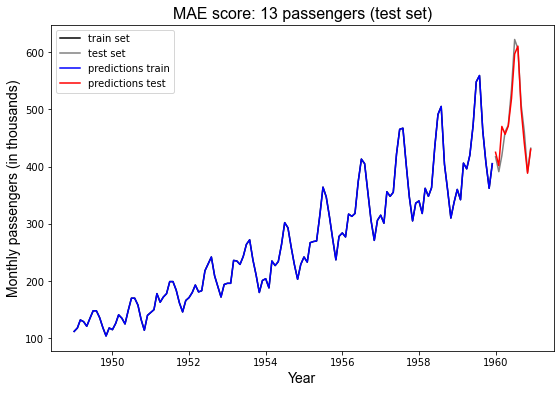

In [33]:
# Plot results

plot_predictions(
    data,
    y_train_3,
    y_test_3,
    y_pred_tr_3,
    y_pred_te_3,
    model_error(y_test_3, y_pred_te_3),
)

Now we have a model that captures the periodic behavior and the trend in the number of airline passengers. This way, we managed to further improve model performance on the test set! 

In the last part of this exercise, we will introduce another type of feature that is commonly used in time-series prediction: *lag features*.

## Fitting a fourth model  

### Feature engineering :: Lag features

Time-series prediction models are often constructed using *lag features* as a means of incorporating information about the past into the model. Let's begin by discussing *how* to build *lag features*. 

If the observation at time t is $y_t$, then, the observation at the previous time-step is $y_{t-1}$, at the previous two time-steps $y_{t-2}$, and so on. We say that $y_{t-1}$ is *lagged* by one period, $y_{t-2}$ by two periods, etc. 

We can create *lag features* with the *pandas.DataFrame.shift* function using the *periods* keyword. Setting *periods=1* means that the time-series will be shifted forward one position and so on. Let's see how this works with an example.

*Note*: We will be working with the *detrended* and *log-transformed* *Passengers* column.

In [34]:
# Create a copy of the data
data2 = data1[["Month", "Year", "Passengers"]].copy()

# Show a few samples
data2.head()

,Month,Year,Passengers
Date,,,
1949-02-01,2,1949,0.052186
1949-03-01,3,1949,0.112117
1949-04-01,4,1949,-0.022990
1949-05-01,5,1949,-0.064022
1949-06-01,6,1949,0.109484


In [35]:
# EXAMPLE
# Create lag features: t-1 and t-2
lags = pd.concat(
    [
        data2["Passengers"].shift(periods=2),
        data2["Passengers"].shift(periods=1),
        data2["Passengers"],
    ],
    axis=1,
)
lags.columns = ["t-2", "t-1", "t"]

# Show a few samples
lags.head()

,t-2,t-1,t
Date,,,
1949-02-01,NaN,NaN,0.052186
1949-03-01,NaN,0.052186,0.112117
1949-04-01,0.052186,0.112117,-0.022990
1949-05-01,0.112117,-0.022990,-0.064022
1949-06-01,-0.022990,-0.064022,0.109484


The column t corresponds to the (detrended and log-transformed) *Passengers* column. *t-1* corresponds to the *Passengers* column shifted forward by one period, and the *t-2* shifted forward by two periods. 

Shifting the time-series has resulted in missing values at the beginning of the lagged features, which we will remove below with the *dropna* method.

In [36]:
# Remove rows with missing values
lags.dropna(inplace=True)

# Show a few samples
lags.head()

,t-2,t-1,t
Date,,,
1949-04-01,0.052186,0.112117,-0.022990
1949-05-01,0.112117,-0.022990,-0.064022
1949-06-01,-0.022990,-0.064022,0.109484
1949-07-01,-0.064022,0.109484,0.091937
1949-08-01,0.109484,0.091937,0.000000


So, we saw *how* to construct *lag features*. Let's now see how to select *meaningful* lag features. 

*Pandas.plotting.lag_plot* is a convenient tool for creating *lag plots* for time-series. Below, we use it to plot the *Passengers* column (*detrended* and *log-transformed*) against lagged features. Each graph shows $y_t$ plotted against $y_{t−lag}$, where *lag* ranges from 1 to 12.

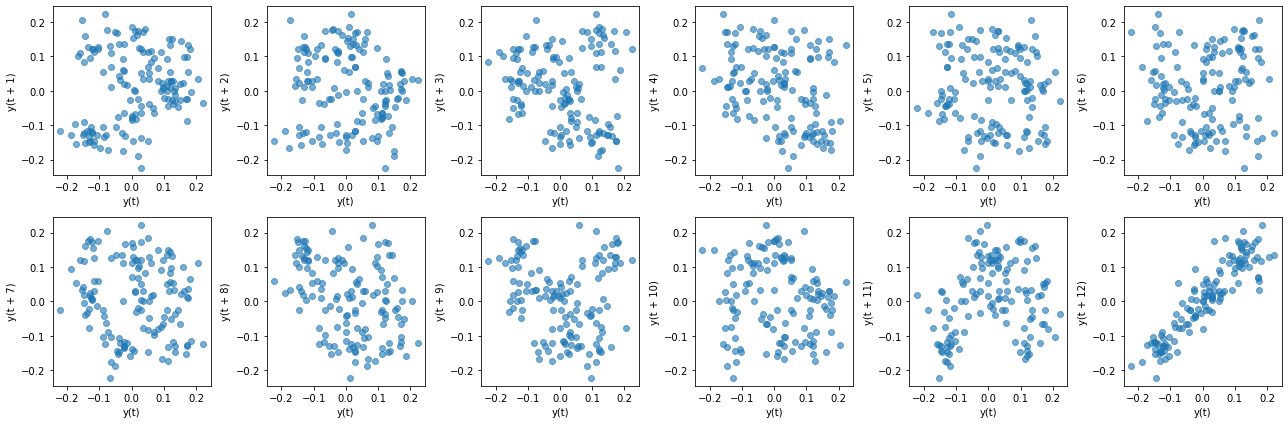

In [37]:
# Lag plot of "Passengers"

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for lag, ax in zip(np.arange(1, 13), axes.ravel()):
    pd.plotting.lag_plot(data2["Passengers"], lag=lag, ax=ax, alpha=0.6)

plt.tight_layout()

We see that *Passengers* is correlated with lag 12; this is due to the seasonality in the data. The rest of the lags show no, or weak correlation with *Passengers*.

In our last model, we will use *lag 12* together with the *Month* and *Year* features.

In [38]:
# New feature: lag 12
data2["t-12"] = data2["Passengers"].shift(12)

# Re-order columns for convenience
data2 = data2[["t-12", "Month", "Year", "Passengers"]].copy()

# Show a few samples
data2.head(15)

,t-12,Month,Year,Passengers
Date,,,,
1949-02-01,NaN,2,1949,0.052186
1949-03-01,NaN,3,1949,0.112117
1949-04-01,NaN,4,1949,-0.022990
1949-05-01,NaN,5,1949,-0.064022
1949-06-01,NaN,6,1949,0.109484
1949-07-01,NaN,7,1949,0.091937
1949-08-01,NaN,8,1949,0.000000
1949-09-01,NaN,9,1949,-0.084557
1949-10-01,NaN,10,1949,-0.133531


In [39]:
# Remove rows with missing values
data2.dropna(inplace=True)

# Show a few samples from the data
data2.head()

,t-12,Month,Year,Passengers
Date,,,,
1950-02-01,0.052186,2,1950,0.091350
1950-03-01,0.112117,3,1950,0.112478
1950-04-01,-0.022990,4,1950,-0.043485
1950-05-01,-0.064022,5,1950,-0.076961
1950-06-01,0.109484,6,1950,0.175633


In [40]:
# Print the shape of the dataframe
print("Data shape: {}".format(data2.shape))

Data shape: (131, 4)


We are now ready to fit our fourth model; *t-12*, *Year* and *Month* are going to be the features and *Passengers* (differenced and log-transformed) the target.

In [41]:
# Split into train/set sets and create X/y arrays

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(data2, test_start_dt)

Train set
---------
Features: (119, 3) Target: (119,)

Test set
--------
Features: (12, 3) Target: (12,)


In [42]:
# Create and fit KNeighborsRegressor

pipe4 = Pipeline(
    [
        ("scaler", StandardScaler()),  # Scaling improves performance
        ("knn", KNeighborsRegressor(n_neighbors=3, p=1, weights="distance")),
    ]
)  # Hyperparameters: tuned with GridSearchCV
pipe4.fit(X_train_4, y_train_4)

# Compute predictions for train/test sets
y_pred_tr_4 = pipe4.predict(X_train_4)
y_pred_te_4 = pipe4.predict(X_test_4)

As in the third model, the target and the predictions are expressed as the month-to-month change in the number of passengers. We will invert differencing using the *invert_differencing* function from above.

However, we need to pay attention to the following:
* differencing threw away the first entry of the target
* shifting the time-series forward by 12 periods threw away the next 12 observations in the target.

We need to put these 13 (1 + 12) values back before calling the *cumsum* function.

In [43]:
# Retrieve thrown away entries
y0 = np.r_[data["Passengers"][0], data1["Passengers"][0:12]]  # length: 13

# Define the number of samples in the train data (before differencing and lagging)
len_train = len(y_train)

# Target: Invert differencing
y_train_4, y_test_4 = invert_differencing(y_train_4, y_test_4, y0, len_train)

# Predictions: Invert differencing
y_pred_tr_4, y_pred_te_4 = invert_differencing(y_pred_tr_4, y_pred_te_4, y0, len_train)

In [44]:
# Model performance
print("Model 4")
print("-------")
print()
print(
    "Train set - MAE score: {:.0f} passengers".format(
        model_error(y_train_4, y_pred_tr_4)
    )
)
print(
    "Test set  - MAE score: {:.0f} passengers".format(
        model_error(y_test_4, y_pred_te_4)
    )
)

Model 4
-------

Train set - MAE score: 0 passengers
Test set  - MAE score: 12 passengers


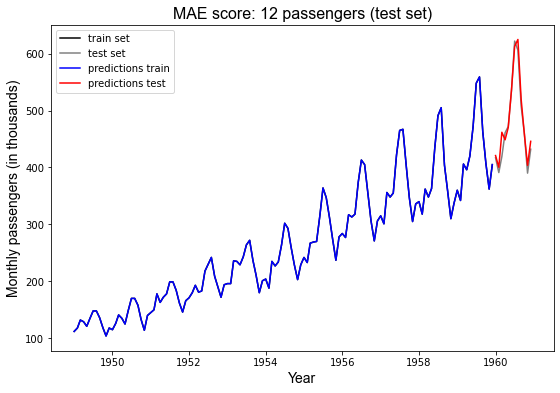

In [45]:
# Plot results

plot_predictions(
    data,
    y_train_4,
    y_test_4,
    y_pred_tr_4,
    y_pred_te_4,
    model_error(y_test_4, y_pred_te_4),
)

## Final model comparison

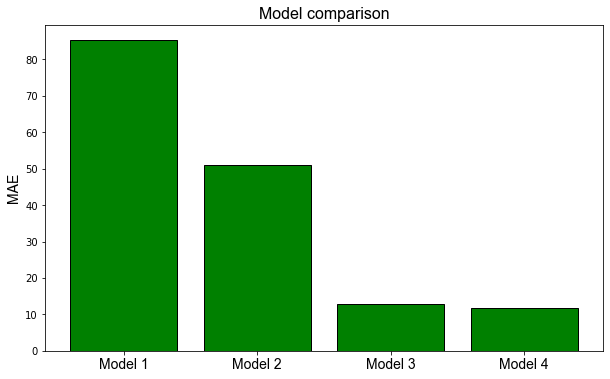

In [46]:
# Final comparison

font = {"fontname": "Arial", "size": "14"}
font_title = {"fontname": "Arial", "size": "16"}

plt.figure(figsize=(10, 6))

labels = ["Model 1", "Model 2", "Model 3", "Model 4"]

mae_values = [
    model_error(y_test, y_pred_te),  # MAE :  model 1
    model_error(y_test_2, y_pred_te_2),  # MAE :  model 2
    model_error(y_test_3, y_pred_te_3),  # MAE :  model 3
    model_error(y_test_4, y_pred_te_4),  # MAE :  model 4
]

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values, color="g", edgecolor="black")
plt.xticks(xcor, labels, **font)
plt.ylabel("MAE", **font)
plt.title("Model comparison", **font_title)
plt.show()

## Summary

* Creating *meaningful* features is essential for building good machine learning models. In this exercise, we explored *date-time* and *lag* features and achieved good model performances.

* In time-series data, transformations such as applying the logarithm and differencing can help to stabilize the *non-stationarity* in the variance and the mean, respectively, and improve model performance. However, there is no "one-size-fits-all" solution; other types of transformations (inverse, square root, cubic root, etc.) may work better depending on the time-series data and the model used.

* Transformations need to be inverted to turn the observations back to their original scale. Log-transformations (natural base) can be reversed by applying the exponential function. Differencing can be reversed using the cumulative sum (*cumsum*) function.

* The *KNeighborsRegressor* model is not the only Machine Learning model that can be used for time-series prediction! Feel free to experiment time-series forecasting with other models: LinearRegression, RandomForestRegressor, and neural networks!